In [1]:
# Read the data

inFile = open("sp500.txt", 'r')

List = []
for line in inFile:
    List.append(line.replace(',', '.'))
inFile.close()

ListNum1 = []

for ind in range(len(List)):
    sss = List[ind]
    ListNum1.append(float(sss))
ListNum = ListNum1[::-1]
price = ListNum[253:]

In [2]:
# Get medians

inFile = open("median.txt", 'r')

List = []
for line in inFile:
    List.append(line.replace(',', '.'))
inFile.close()

median = []
for ind in range(len(List)):
    sss = List[ind]
    median.append(float(sss))

In [3]:
# Get 1st quantiles

inFile = open("quartile1st.txt", 'r')

List = []
for line in inFile:
    List.append(line.replace(',', '.'))
inFile.close()

qu1 = []
for ind in range(len(List)):
    sss = List[ind]
    qu1.append(float(sss))

In [4]:
# Get 3rd quantiles

inFile = open("quartile3rd.txt", 'r')

List = []
for line in inFile:
    List.append(line.replace(',', '.'))
inFile.close()

qu3 = []
for ind in range(len(List)):
    sss = List[ind]
    qu3.append(float(sss))

As usual, I downloaded all three quantiles for SP500 ETF issued by iShares calculated for the previous one year period. As two previous attempts (MC1 and MC2) produced disappointingly low returns (compared to 2 year Treasury notes) I need to try a slightly more sophisticated strategy. MC1 and MC2, in effect, made a bet if the price is good. The whole sum availabe was invested or the whole block of ETF shares was sold. In fact, the Agent could buy several shares, then if the price moves lower, buy some more shares. Of course, too many purchases are puniched by the fee of 9.99 USD (brokerage fee). So the action space is discrete but with a pretty large number of options.

I want to investigate a strategy - invest (approximately) half of the money if the price seems good (with probability p1), invest the rest of the money if the price goes down by k1 factor. If the Agent is fully invested, it can sell half of its shares if the price high enough (with probability p2) and sell all the rest if the price goes up even further (k2 times). In the intermediate state ("half-cash half shares") the Agent either sells all its shares or invest (almost) all its money.

So The Agent starts in state S1 - "all cash", moves to state S2 ("half cah - half money") with probability p1 or moves to State S3 ("fully invested", very little money is left) with probability 1-p1. Similarly it moves from state S3 to S2 with probabilty p2 and to state S1 with probability 1-p1. This hapens when the 1st or 3rd quantile is reached. (Buy low - sell high). If the Agent is in state S2 and can get a better price (Buy even lower and sell even higher) it acts with 100% probability.

In [6]:
import random
import math

In [25]:
def runEpisode1(ind, p1, p2, k1=0.95, k2=1.05, price=price, median=median, qu1=qu1, qu3=qu3):
    cash = 10000
    flag = 0 # 0 is state S1, 1 is state S2, 2 is state S3
    nshares = 0
    fee = 9.99
    nmax = 507
    
    for i in range(ind, (ind+nmax-1)):
        if price[i] < qu1[i]:
            # Buy!
            if flag == 0:
                action = random.choices(['all', 'half'], [1-p1, p1]) # invest all the money or half the money
                if action[0] == 'all':
                    nshares = ((cash-fee)/price[i])//1
                    cash = cash - nshares*price[i] - fee
                    if nshares: flag = 2
                else:
                    nshares = math.ceil((0.5*cash)/price[i])
                    cash = cash - nshares*price[i] - fee
                    if nshares:
                        flag = 1
            elif flag == 1:
                if price[i] < k1*qu1[i]:
                    n = ((cash-fee)/price[i])//1
                    nshares += n
                    cash = cash - n*price[i] - fee
                    if n: flag = 2
        elif price[i] > qu3[i]:
            # Sell!
            if flag == 2:
                action = random.choices(['all', 'half'], [1-p2, p2]) # sell all the shares or half of them
                if action[0] == 'all':
                    cash = cash + nshares*price[i] - fee
                    nshares = 0
                    flag = 0
                else:
                    n = math.ceil(0.5*nshares)
                    cash = cash + n*price[i] - fee
                    nshares -= n
                    if nshares:
                        flag = 1
                    else: flag = 0
            elif flag == 1:
                if price[i] > k2*qu3[i]:
                    cash = cash + nshares*price[i] - fee
                    nshares = 0
                    flag = 0
                    
    if nshares:
        cash = cash + nshares*price[ind+nmax-1] - fee
    
    return cash - 10000

In [21]:
import numpy as np

Does it work at all? In the next two cells I see how large the variance is!

In [26]:
p1 = 0.5
p2 = 0.5

gain = []

for ind in random.sample(range(3650), 1600):
    gain.append(runEpisode1(ind, p1, p2))
    
g = np.array(gain)
print (np.mean(g), np.std(g))

279.0142687500007 1685.1970521738226


In [27]:
p1 = 0.5
p2 = 0.5

gain = []

for ind in random.sample(range(3650), 1600):
    gain.append(runEpisode1(ind, p1, p2))
    
g = np.array(gain)
print (np.mean(g), np.std(g))

252.0261750000006 1743.3193963741255


In [30]:
p1 = 0.5
p2 = 0.5

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

250.20940837500072 30.68015416205089


In [31]:
p1 = 0.75
p2 = 0.75

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

238.40488162500068 31.519784060961786


In [32]:
p1 = 1.0
p2 = 1.0

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

233.16205325000072 30.60466876305953


In [33]:
p1 = 0.25
p2 = 0.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

254.5070042500007 32.867445103183265


In [34]:
p1 = 0
p2 = 0

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

237.2792319375007 30.69901347185957


In [35]:
p1 = 0
p2 = 0

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

230.89570050000074 33.44830967817832


In [36]:
p1 = 0.1
p2 = 0.1

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

248.91529168750068 33.71207843745589


In [37]:
p1 = 0.2
p2 = 0.2

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

249.27792518750067 33.40868726083206


In [38]:
p1 = 0.3
p2 = 0.3

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

253.12555056250065 30.576306168311262


In [39]:
p1 = 0.4
p2 = 0.4

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

246.37424218750067 30.798600878590975


In [40]:
p1 = 0.35
p2 = 0.35

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

249.11536862500066 34.45484946430992


In [41]:
p1 = 0.3
p2 = 0.3

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

255.94499412500068 28.1422889367632


In [42]:
p1 = 0.25
p2 = 0.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

257.0711854375007 32.00350624293889


In [43]:
p1 = 0.25
p2 = 0.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

252.12323412500072 38.60135761520104


This seems the best average return I could see so far with default values of k1 and k2. Maybe k1 and k2 could improve the result?

In [44]:
p1 = 0.25
p2 = 0.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

263.89147337500066 34.40171909621504


In [45]:
p1 = 0.25
p2 = 0.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

249.4876794375007 30.354005582918568


In [47]:
p1 = 0.25
p2 = 0.25

k1 = 0.99
k2 = 1.01

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

194.9666150000007 29.638950582029835


In [48]:
p1 = 0.25
p2 = 0.25

k1 = 0.98
k2 = 1.02

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

197.1494351250006 36.06310714532443


In [49]:
p1 = 0.25
p2 = 0.25

k1 = 0.97
k2 = 1.03

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

191.22294800000068 33.209053623764866


In [50]:
p1 = 0.25
p2 = 0.25

k1 = 0.96
k2 = 1.04

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

225.26951637500068 34.51801663324405


In [51]:
p1 = 0.25
p2 = 0.25

k1 = 0.95  # default value
k2 = 1.05  # default value

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

254.43702068750065 28.346617556031212


In [52]:
p1 = 0.25
p2 = 0.25

k1 = 0.94
k2 = 1.06

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

287.2280023750006 33.61693907079068


In [53]:
p1 = 0.25
p2 = 0.25

k1 = 0.93
k2 = 1.07

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

327.1788026875007 34.819294307710564


In [54]:
p1 = 0.25
p2 = 0.25

k1 = 0.92
k2 = 1.08

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

318.34923612500063 33.74719741288203


In [55]:
p1 = 0.25
p2 = 0.25

k1 = 0.91
k2 = 1.09

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

343.2562734375008 31.555594811423227


In [56]:
p1 = 0.25
p2 = 0.25

k1 = 0.9
k2 = 1.1

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

347.58165318750054 31.67823535909741


In [57]:
p1 = 0.25
p2 = 0.25

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

379.93827937500066 31.28642907007415


In [58]:
p1 = 0.25
p2 = 0.25

k1 = 0.88
k2 = 1.12

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

309.9752911250005 31.328469057882415


In [59]:
p1 = 0.25
p2 = 0.25

k1 = 0.88
k2 = 1.12

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

309.04457631250057 31.76740884101184


In [60]:
p1 = 0.25
p2 = 0.25

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

379.6851840000007 34.29302339308526


In [61]:
p1 = 0.25
p2 = 0.25

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

373.3188911250007 31.198547408622236


In [62]:
p1 = 0.25
p2 = 0.25

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

377.8214850625006 37.687600131949935


In [63]:
p1 = 0.2
p2 = 0.2

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

358.56092537500075 31.441777475749248


In [64]:
p1 = 0.15
p2 = 0.15

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

337.1813996250006 32.34567686420897


In [65]:
p1 = 0.1
p2 = 0.1

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

306.0390248125007 36.8192469657755


In [66]:
p1 = 0.3
p2 = 0.3

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

396.9489918125007 31.546514173861627


In [67]:
p1 = 0.35
p2 = 0.35

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

408.49602543750063 31.130718321825817


In [68]:
p1 = 0.4
p2 = 0.4

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

420.9213498750006 34.041317702700674


In [69]:
p1 = 0.45
p2 = 0.45

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

428.08753493750066 30.249810452856984


In [70]:
p1 = 0.5
p2 = 0.5

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

431.0248299375006 30.747345166725495


In [71]:
p1 = 0.55
p2 = 0.55

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

434.04479925000066 29.97715444298705


In [72]:
p1 = 0.6
p2 = 0.6

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

438.21315381250054 33.97397837443448


In [73]:
p1 = 0.65
p2 = 0.65

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

441.2661801875006 35.1089147357712


In [74]:
p1 = 0.7
p2 = 0.7

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

444.84369350000065 30.27765806360856


In [75]:
p1 = 0.75
p2 = 0.75

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

440.46636287500064 32.73055196088941


In [76]:
p1 = 0.8
p2 = 0.8

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

435.60129368750063 30.478456769721102


In [77]:
p1 = 0.7
p2 = 0.7

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

442.4443096250007 27.96811599145453


In [78]:
p1 = 0.7
p2 = 0.7

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

441.2369963750007 31.540209471300468


In [79]:
p1 = 0.7
p2 = 0.7

k1 = 0.9
k2 = 1.1

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

380.5365539375006 33.22513647461953


In [80]:
p1 = 0.7
p2 = 0.7

k1 = 0.91
k2 = 1.09

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

365.04944237500087 32.46003545596775


In [81]:
p1 = 0.7
p2 = 0.7

k1 = 0.92
k2 = 1.08

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

373.32435512500064 36.0349373419372


In [82]:
p1 = 0.7
p2 = 0.7

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

445.1496371875006 27.859385803487022


In [83]:
p1 = 0.7
p2 = 0.7

k1 = 0.88
k2 = 1.12

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

363.9740669375006 27.107377817820257


In [84]:
p1 = 0.7
p2 = 0.7

k1 = 0.88
k2 = 1.12

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

364.30040193750057 28.533718478377228


In [85]:
p1 = 0.7
p2 = 0.7

k1 = 0.87
k2 = 1.13

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

372.0377652500006 27.587090783991727


In [86]:
p1 = 0.7
p2 = 0.7

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

446.4450705000007 31.008170446742838


In [87]:
p1 = 0.75
p2 = 0.7

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

438.72828806250067 32.56570624328204


In [88]:
p1 = 0.7
p2 = 0.75

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

447.0754900000006 28.679989552776576


In [89]:
p1 = 0.75
p2 = 0.75

k1 = 0.89
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

442.73398556250066 29.861445453208137


In [90]:
p1 = 0.7
p2 = 0.75

k1 = 0.9
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

403.61824606250053 30.202129061333686


In [91]:
p1 = 0.7
p2 = 0.75

k1 = 0.88
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

476.62885256250064 30.602333663251756


In [92]:
p1 = 0.7
p2 = 0.75

k1 = 0.89
k2 = 1.1

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

425.20332037500054 30.694750592415968


In [93]:
p1 = 0.7
p2 = 0.75

k1 = 0.89
k2 = 1.12

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

342.4770450625006 29.27939582987236


This is the best return I could see so far (interestingly, the policy is stochastic.):

In [94]:
p1 = 0.7
p2 = 0.75

k1 = 0.88
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

481.95782156250084 33.05526867758582


In [95]:
p1 = 0.7
p2 = 0.75

k1 = 0.88
k2 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode1(ind, p1, p2, k1, k2))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

477.6350636250006 31.018960261887564


OK. First, stochastic policy does produce better return than deterministic.

This seems to be the best parameter combination seen so far. The system has no memory! From state S2 the agent sells all shares or invest all the money it has when price passes the thresholds. While in states S1 and S3 the next action is chosen randomly (with probabilities determined by p1 and p2).

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([ 1.,  3.,  5., 10., 17., 25., 18., 14.,  3.,  4.]),
 array([383.25959375, 400.43918438, 417.618775  , 434.79836563,
        451.97795625, 469.15754688, 486.3371375 , 503.51672813,
        520.69631875, 537.87590938, 555.0555    ]),
 <a list of 10 Patch objects>)

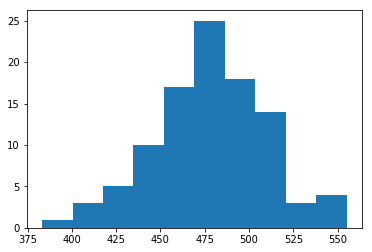

In [97]:
plt.hist(av_gain)

(array([ 22., 131., 138., 630., 405., 215.,  49.,   4.,   4.,   2.]),
 array([-4518.23 , -3245.626, -1973.022,  -700.418,   572.186,  1844.79 ,
         3117.394,  4389.998,  5662.602,  6935.206,  8207.81 ]),
 <a list of 10 Patch objects>)

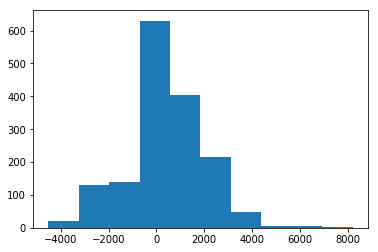

In [98]:
plt.hist(gain)

Let's see how the model works for the test set:

In [99]:
p1 = 0.7
p2 = 0.75

k1 = 0.88
k2 = 1.11

test_gain = []

for i in range(3651, 3751):
    test_gain.append(runEpisode1(i, p1, p2, k1, k2))

In [100]:
tg = np.array(test_gain)
print (np.mean(tg), np.std(tg))

1437.2572000000002 1027.0561749398912


(array([26.,  4.,  3.,  3., 12., 16.,  4., 15., 15.,  2.]),
 array([   0.   ,  318.912,  637.824,  956.736, 1275.648, 1594.56 ,
        1913.472, 2232.384, 2551.296, 2870.208, 3189.12 ]),
 <a list of 10 Patch objects>)

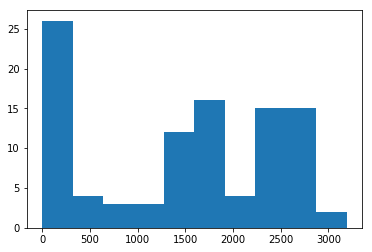

In [101]:
plt.hist(test_gain)

Much better than expected. In two years, the test data produce average total return of 14.37%

## Model 2

Let's try and add some memory. It doesn't matter how the Agent got to states S1 or S3. It starts from state S1. Afterwards it gets in state S1 if the price went high enough - it just sold any shares it had. Similarly, the Agent can get to state S3 only if the price drops sufficiently to justify purchase of the shares.

The previous state (kept in the variable flagPrev) matters in state S2 (half cash, half shares). If the Agent started from state S3 and the price continues to surge, we have all reasons to hope for a bull run. Then the Agent may be a little more aggressive, i.e. sell at slightly higher price compared to a case when it got to S2 from S1. Similarly, if the Agent started from state S1, then got to state S2, we could believe in a bear so the Agent would wait for even more attractive (low) price than if it got to S2 from S3. The exact level of "even higher/lower price" is determined by tuning parameters (k1, k2, k3, k4). Let's try this strategy! 

In [103]:
def runEpisode2(ind, p1, p2, k1=0.95, k2=1.05, k3=0.9, k4=1.1, price=price, median=median, qu1=qu1, qu3=qu3):
    cash = 10000
    flag = 0 # 0 is state S1, 1 is state S2, 2 is state S3
    nshares = 0
    fee = 9.99
    nmax = 507
    flagPrev = None
    
    for i in range(ind, (ind+nmax-1)):
        if price[i] < qu1[i]:
            # Buy!
            if flag == 0:
                action = random.choices(['all', 'half'], [1-p1, p1]) # invest all the money or half the money
                if action[0] == 'all':
                    nshares = ((cash-fee)/price[i])//1
                    cash = cash - nshares*price[i] - fee
                    if nshares: flag = 2
                else:
                    nshares = math.ceil((0.5*cash)/price[i])
                    cash = cash - nshares*price[i] - fee
                    if nshares:
                        flagPrev = 0
                        flag = 1
            elif flag == 1:
                if flagPrev == 0:
                    k = k3
                else: k = k1
                if price[i] < k*qu1[i]:
                    n = ((cash-fee)/price[i])//1
                    nshares += n
                    cash = cash - n*price[i] - fee
                    if n: flag = 2
        elif price[i] > qu3[i]:
            # Sell!
            if flag == 2:
                action = random.choices(['all', 'half'], [1-p2, p2]) # sell all the shares or half of them
                if action[0] == 'all':
                    cash = cash + nshares*price[i] - fee
                    nshares = 0
                    flag = 0
                else:
                    n = math.ceil(0.5*nshares)
                    cash = cash + n*price[i] - fee
                    nshares -= n
                    if nshares:
                        flagPrev = 2
                        flag = 1
                    else: flag = 0
            elif flag == 1:
                if flagPrev == 2:
                    k = k4
                else: k = k2  # flagPrev == 0 
                if price[i] > k*qu3[i]:
                    cash = cash + nshares*price[i] - fee
                    nshares = 0
                    flag = 0
                    
    if nshares:
        cash = cash + nshares*price[ind+nmax-1] - fee
    
    return cash - 10000

In [143]:
p1 = 0.7
p2 = 0.75

k1 = 0.89
k2 = 1.1
k3 = 0.89
k4 = 1.1

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

425.9345073125005 29.761795871365187


Don't forget: k3 is less than k1 and k4 is more than k2 e.g.

k1=0.95, k2=1.05, k3=0.9, k4=1.1

In [144]:
p1 = 0.7
p2 = 0.7

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

416.5801526875007 28.59402009295011


In [145]:
p1 = 0.75
p2 = 0.75

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

420.41182762500046 29.500588077325453


In [146]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

423.7419291875007 30.020999878113713


In [147]:
p1 = 0.85
p2 = 0.85

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

418.00359593750056 30.581797799403027


In [148]:
p1 = 0.9
p2 = 0.9

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

414.1169688750006 30.43493769415107


In [149]:
p1 = 1.0
p2 = 1.0

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

413.29727000000065 24.711489025453407


In [150]:
p1 = 0.6
p2 = 0.6

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

417.49766543750064 28.54886238777704


In [151]:
p1 = 0.5
p2 = 0.5

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

416.7075870000006 31.095156525419856


In [152]:
p1 = 0.4
p2 = 0.4

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

402.1544803125006 31.68076096471199


In [153]:
p1 = 0.3
p2 = 0.3

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

381.2771198125007 33.88790257720996


In [154]:
p1 = 0.2
p2 = 0.2

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

353.2582431875006 30.816114124313675


In [155]:
p1 = 0.1
p2 = 0.1

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

304.4873194375007 31.121329142727728


In [156]:
p1 = 0
p2 = 0

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

236.8217838750007 29.288509386148522


In [157]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

414.1795519375006 31.509399437677907


In [158]:
p1 = 0.8
p2 = 0.8

k1 = 0.92
k2 = 1.08
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

356.5940596875004 29.3436635223517


In [159]:
p1 = 0.8
p2 = 0.8

k1 = 0.94
k2 = 1.06
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

278.3593217500004 26.934158734968403


In [160]:
p1 = 0.8
p2 = 0.8

k1 = 0.96
k2 = 1.04
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

202.1537525000005 30.96656594273643


In [161]:
p1 = 0.8
p2 = 0.8

k1 = 0.98
k2 = 1.02
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

123.38177206250054 26.18678793667873


In [162]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.89
k4 = 1.11

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

418.29361006250065 32.31189817062963


In [163]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.88
k4 = 1.12

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

427.0429702500007 29.292952156130195


In [164]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.87
k4 = 1.13

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

428.14348962500065 28.139632154763284


In [165]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.86
k4 = 1.14

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

432.05655893750054 28.003424450999198


In [166]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.85
k4 = 1.15

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

459.8910850625005 25.268940338898133


In [167]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.84
k4 = 1.16

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

465.80310275000056 28.313835089758616


In [168]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.83
k4 = 1.17

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

466.5178156250006 29.507529799805432


In [169]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.82
k4 = 1.18

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

507.9058956875005 26.149910125529704


In [170]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.81
k4 = 1.19

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

508.43979906250047 23.193786660751822


In [171]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.8
k4 = 1.2

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

524.4952937500005 26.665679814769927


In [172]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.79
k4 = 1.21

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

524.1322154375005 25.73827312149266


In [173]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.78
k4 = 1.22

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

535.7352673750005 22.856104194652225


In [174]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.77
k4 = 1.23

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

545.5250563125005 27.31421228741378


In [175]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.76
k4 = 1.24

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

572.6880870625006 23.71564372927533


In [176]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

581.3997704375006 22.564957256316823


In [177]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.74
k4 = 1.26

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

538.5901440000005 24.85197219782899


In [178]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.73
k4 = 1.27

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

530.9943238750005 27.705558593970206


In [179]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.72
k4 = 1.28

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

537.8203551875006 26.527506763989066


In [180]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.71
k4 = 1.29

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

538.0000807500005 24.895987152795197


In [181]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.7
k4 = 1.3

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

555.9281778750005 22.77903660586985


In [182]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.7
k4 = 1.3

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

560.0171526250006 23.908923196975433


In [183]:
p1 = 0.8
p2 = 0.8

k1 = 0.9
k2 = 1.1
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

581.3813361250006 27.97498524018431


In [184]:
p1 = 0.8
p2 = 0.8

k1 = 0.89
k2 = 1.09
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

539.7035218125005 25.30684404345853


In [185]:
p1 = 0.8
p2 = 0.8

k1 = 0.88
k2 = 1.08
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

495.1576170625005 21.170027057462526


In [186]:
p1 = 0.8
p2 = 0.8

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

602.8729596875005 26.728116994308873


In [187]:
p1 = 0.8
p2 = 0.8

k1 = 0.88
k2 = 1.12
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

518.7168346875004 23.955011230115943


In [188]:
p1 = 0.8
p2 = 0.8

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

597.3778627500005 23.72380624844311


In [189]:
p1 = 0.8
p2 = 0.8

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

600.5824118125006 22.177811095622484


In [190]:
p1 = 0.8
p2 = 0.8

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

596.8166392500007 24.62088287741503


In [191]:
p1 = 0.8
p2 = 0.8

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

603.3274790625006 18.133368696748093


Ok, these parameters seem to produce the total return about 600 in 2 years. Nice.

In [192]:
p1 = 0.8
p2 = 0.75

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

600.3440068750006 22.181761321969088


In [193]:
p1 = 0.75
p2 = 0.8

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

595.3962168750005 27.40650442720835


In [194]:
p1 = 0.75
p2 = 0.75

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

588.3232726875005 26.61390889961949


In [195]:
p1 = 0.85
p2 = 0.8

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

604.3105174375006 25.000404794227563


In [196]:
p1 = 0.8
p2 = 0.85

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

606.0382773750006 21.550135098907298


In [197]:
p1 = 0.85
p2 = 0.85

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

611.8115354375005 27.8785953466631


In [198]:
p1 = 0.85
p2 = 0.85

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

614.3592706875005 26.18372483121093


In [199]:
p1 = 0.85
p2 = 0.85

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

611.4575803125006 23.516005464201342


In [201]:
p1 = 0.9
p2 = 0.85

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

616.1348000000007 21.988311479267953


In [202]:
p1 = 0.85
p2 = 0.9

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

614.6859845000006 23.44860836927653


In [203]:
p1 = 0.9
p2 = 0.9

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

622.5519918750008 23.830565764396034


In [204]:
p1 = 0.9
p2 = 0.9

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

627.3637068750005 22.126715531227614


In [205]:
p1 = 0.9
p2 = 0.9

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

626.7980005625006 20.225798161821746


In [206]:
p1 = 0.9
p2 = 0.9

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

628.0618574375006 21.9975785884644


In [207]:
p1 = 0.95
p2 = 0.9

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

631.6794576250006 21.62617705054457


In [208]:
p1 = 0.9
p2 = 0.95

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

625.6242045625006 25.029058520521748


In [209]:
p1 = 0.95
p2 = 0.95

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

634.7967285000008 22.707008628244207


In [210]:
p1 = 1.0
p2 = 1.0

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

640.6715960000006 23.720626383748396


In [211]:
p1 = 1.0
p2 = 1.0

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

645.1643848750006 20.83326007027234


In [212]:
p1 = 1.0
p2 = 1.0

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

643.4453230625006 26.678392083409406


In [213]:
p1 = 1.0
p2 = 1.0

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

645.0867941250008 19.760438036054317


In [214]:
p1 = 1.0
p2 = 1.0

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

643.7472385000005 22.395193238872025


In [215]:
p1 = 1.0
p2 = 1.0

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

av_gain = []
for epoch in range(100):
    gain = []
    for ind in random.sample(range(3650), 1600):
        gain.append(runEpisode2(ind, p1, p2, k1, k2, k3, k4))
    g = np.array(gain)
    av_gain.append(np.mean(g))
    
av = np.array(av_gain)
print (np.mean(av), np.std(av))

641.8074520625007 23.51362331291693


Very interesting. It seems that we again end up with a deterministic policy....p1 = 100% and p2 = 100%

Let's turn to the test set:

In [216]:
p1 = 1.0
p2 = 1.0

k1 = 0.89
k2 = 1.11
k3 = 0.75
k4 = 1.25

test_gain = []

for i in range(3651, 3751):
    test_gain.append(runEpisode2(i, p1, p2, k1, k2, k3, k4))

In [217]:
tg = np.array(test_gain)
print (np.mean(tg), np.std(tg))

1558.6718000000003 1004.6348558689174


(array([26.,  0.,  0.,  0.,  2., 27.,  3., 11., 20., 11.]),
 array([   0.   ,  291.442,  582.884,  874.326, 1165.768, 1457.21 ,
        1748.652, 2040.094, 2331.536, 2622.978, 2914.42 ]),
 <a list of 10 Patch objects>)

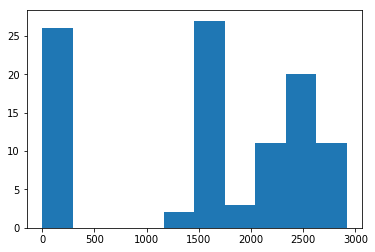

In [218]:
plt.hist(test_gain)

In [219]:
np.min(tg)

0.0

In [220]:
np.max(tg)

2914.42

Let's sum up. The best return with just one intermediate state (the simplest discretisation of the Action space - invest half the money, then the other half if the price is good; if fully invested - sell half your shares then the other half, if the price is right, of course) was achieved for a deterministic policy. The Agents used its memory, the threshold prices were influenced by the previous action of the Agent. This means that the system lost its Markov property. This makes life hard. I could consider the states determined by the external variable - share price and the current portfolio status (S1, S2, or S3) as pairs of aliased states with one more hidden parameter - the market sentiment. But to do this, I'll need to figure out how to determine the value of the market sentiment value (e.g. positive, neutral, negative) from the price history before the current date.